# Bayesian Semi-parametric Survival Analysis Notebook

by Michael Wamberg & Bjarke Hastrup

# The equivalent poisson model

Survival function:  $$S(t)=exp\left(-\int_0^t \lambda(u)du\right)$$

Cox proportional hazard:$$\lambda_{ij} =\lambda_{j} \exp(\mathbf{x}_{i}^{T}\boldsymbol{\beta})$$

Likelihood contribution from i'th individual, who dies or is censored in j'th time interval:    $\nu_i=1$ for death, 0 otherwise

\begin{align*}
L_i(\boldsymbol{\beta},\boldsymbol{\lambda} | D_{i})
&= (\lambda_{j} \exp(\mathbf{x}_{i}^{T}\boldsymbol{\beta}))^{\delta_{ij}\nu_{i}} \exp \left\{ - \delta_{ij} \left[ \lambda_{j}(y_{i} - s_{j-1}) + \sum^{j-1}_{g=1} \lambda_{g}(s_{g} - s_{g-1}) \right] \exp(\mathbf{x}_{i}^{T}\boldsymbol{\beta}) \right\}\\
 &= \prod^{j}_{g=1} \exp \left\{ - \lambda_{g} t_{i,g} \exp(\mathbf{x}_{i}^{T}\boldsymbol{\beta}) \right\} (\lambda_{g} t_{i,g} \exp(\mathbf{x}_{i}^{T}\boldsymbol{\beta}))^{\delta_{i,g} \nu_{i}} \big/ (\delta_{i,g} \nu_{i})!\\
\end{align*}

We recognize this as poisson likelihood: $\frac{\mu e^{-\mu}}{k!}$.

$$
\log(\mu_{i,g})= \log(t_{i,g}) + \log(\lambda_{g}) + \mathbf{x}_{i}^{T}\boldsymbol{\beta}\\
$$


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import random
random.seed(1100038344)
import survivalstan
import numpy as np
import pandas as pd
from stancache import stancache
from matplotlib import pyplot as plt
import statsmodels
import pystan
from sklearn import preprocessing
#from pandas_ods_reader import read_ods

INFO:stancache.seed:Setting seed to 1245502385


In [2]:
# matplotlib options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [3]:
# matplotlib options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [4]:
df = pd.read_csv('E18.csv')
df.head()
#len(df)

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,goal_time_h,goal_time_a,finished,red_cards_h,...,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
0,E0,10/08/2018,Man United,Leicester,2,1,"3,83",91,94,NaN,...,1.79,17,-0.75,1.75,1.70,2.29,2.21,1.55,4.07,7.69
1,E0,11/08/2018,Bournemouth,Cardiff,2,0,"24,91",NaN,95,NaN,...,1.83,20,-0.75,2.20,2.13,1.80,1.75,1.88,3.61,4.70
2,E0,11/08/2018,Fulham,Crystal Palace,0,2,NaN,"41,80",95,NaN,...,1.87,22,-0.25,2.18,2.11,1.81,1.77,2.62,3.38,2.90
3,E0,11/08/2018,Huddersfield,Chelsea,0,3,NaN,"34,45,80",93,NaN,...,1.84,23,1.00,1.84,1.80,2.13,2.06,7.24,3.95,1.58
4,E0,11/08/2018,Newcastle,Tottenham,1,2,11,"8,18",95,NaN,...,1.81,20,0.25,2.20,2.12,1.80,1.76,4.74,3.53,1.89


In [5]:
#df.dtypes

In [6]:
ikke_nan_h = df['goal_time_h'].isnull() == False
ikke_nan_a = df['goal_time_a'].isnull() == False

In [7]:
df['t'] = df['finished']
df['dead'] = 0
df['t1_h'] = df['finished']
df['t1_a'] = df['finished']
for i in range(len(df)):
    if ikke_nan_h[i] == True:
        df.loc[i,'dead'] = 1
        string = df.loc[i,'goal_time_h']
        try:
            substr = string[:string.index(",")]
            df.loc[i, 't1_h'] = float(substr)
        except:
            substr = df.loc[i,'goal_time_h']
            df.loc[i,'t1_h'] = float(substr)
    
    if ikke_nan_a[i] == True:
        df.loc[i,'dead'] = 1
        string = df.loc[i,'goal_time_a']
        try:
            substr = string[:string.index(",")]
            df.loc[i,'t1_a'] = float(substr)
        except:
            substr = df.loc[i,'goal_time_a']
            df.loc[i,'t1_a'] = float(substr)
    
    first_goal = min(df.loc[i,'t1_h'], df.loc[i,'t1_a'])
    if first_goal < df.loc[i,'t']:
        df.loc[i,'t'] = first_goal

In [8]:
df['skill_gap'] = np.abs(df['PSCH'] - df['PSCA'])

In [9]:
# df['skill_gap']  = 0
# for i in range(len(df)):
#     if np.abs(df['PSCH'][i] - df['PSCA'][i]) > 5:
#         df.loc[i, 'skill_gap'] = 1
#     else:
#         df[i, 'skill_gap'] = 0

In [10]:
df.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,goal_time_h,goal_time_a,finished,red_cards_h,...,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA,t,dead,t1_h,t1_a,skill_gap
0,E0,10/08/2018,Man United,Leicester,2,1,"3,83",91,94,NaN,...,2.29,2.21,1.55,4.07,7.69,3.0,1,3.0,91.0,6.14
1,E0,11/08/2018,Bournemouth,Cardiff,2,0,"24,91",NaN,95,NaN,...,1.80,1.75,1.88,3.61,4.70,24.0,1,24.0,95.0,2.82
2,E0,11/08/2018,Fulham,Crystal Palace,0,2,NaN,"41,80",95,NaN,...,1.81,1.77,2.62,3.38,2.90,41.0,1,95.0,41.0,0.28
3,E0,11/08/2018,Huddersfield,Chelsea,0,3,NaN,"34,45,80",93,NaN,...,2.13,2.06,7.24,3.95,1.58,34.0,1,93.0,34.0,5.66
4,E0,11/08/2018,Newcastle,Tottenham,1,2,11,"8,18",95,NaN,...,1.80,1.76,4.74,3.53,1.89,8.0,1,11.0,8.0,2.85


In [11]:
scaler = preprocessing.StandardScaler()
df.loc[:, 'skill_gap'] = scaler.fit_transform(np.asarray(df.loc[:, 'skill_gap']).reshape(-1, 1))

In [12]:
#df = pd.read_csv('valung.csv')
#df.head()
len(df)

380

In [13]:
#df.dead[df.dead == 'dead'] = 1;
#df.dead[df.dead == 'censored'] = 0;

In [14]:
df.dead = df.dead.astype(int)

In [15]:
df.head(100)

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,goal_time_h,goal_time_a,finished,red_cards_h,...,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA,t,dead,t1_h,t1_a,skill_gap
0,E0,10/08/2018,Man United,Leicester,2,1,"3,83",91,94,NaN,...,2.29,2.21,1.55,4.07,7.69,3.0,1,3.0,91.0,0.155606
1,E0,11/08/2018,Bournemouth,Cardiff,2,0,"24,91",NaN,95,NaN,...,1.80,1.75,1.88,3.61,4.70,24.0,1,24.0,95.0,-0.393243
2,E0,11/08/2018,Fulham,Crystal Palace,0,2,NaN,"41,80",95,NaN,...,1.81,1.77,2.62,3.38,2.90,41.0,1,95.0,41.0,-0.813145
3,E0,11/08/2018,Huddersfield,Chelsea,0,3,NaN,"34,45,80",93,NaN,...,2.13,2.06,7.24,3.95,1.58,34.0,1,93.0,34.0,0.076254
4,E0,11/08/2018,Newcastle,Tottenham,1,2,11,"8,18",95,NaN,...,1.80,1.76,4.74,3.53,1.89,8.0,1,11.0,8.0,-0.388283
5,E0,11/08/2018,Watford,Brighton,2,0,"35,54",NaN,94,NaN,...,1.90,1.86,2.58,3.08,3.22,35.0,1,35.0,94.0,-0.753631
6,E0,11/08/2018,Wolves,Everton,2,2,"44,80","17,67",94,NaN,...,1.92,1.88,2.44,3.23,3.32,17.0,1,44.0,17.0,-0.713956
7,E0,12/08/2018,Arsenal,Man City,0,2,NaN,"14,64",94,NaN,...,2.21,2.15,4.43,4.13,1.81,14.0,1,94.0,14.0,-0.426306
8,E0,12/08/2018,Liverpool,West Ham,4,0,"19,45,53,88",NaN,93,NaN,...,2.06,1.97,1.25,6.95,12.00,19.0,1,19.0,93.0,0.917712
9,E0,12/08/2018,Southampton,Burnley,0,0,NaN,NaN,95,NaN,...,1.82,1.76,2.03,3.19,4.65,95.0,0,95.0,95.0,-0.426306


We can use the survivalstan package to generate survivor function plots:

In [16]:
survivalstan.utils.plot_observed_survival(df=df[df['skill_gap'] == 0], event_col='dead', time_col='t', label='Small skill_gap')
survivalstan.utils.plot_observed_survival(df=df[df['skill_gap'] == 1], event_col='dead', time_col='t', label='Large skill_gap')
plt.legend();
plt.xlabel("Days");
plt.ylabel("Survival probability")

ValueError: zero-size array to reduction operation minimum which has no identity

In [17]:
#df.therapy = (df.therapy == 'test').astype(np.int64)

In [18]:
n_patients = df.shape[0]
patients = np.arange(n_patients)

In [19]:
df_sort = df.sort_values(by=['t'])

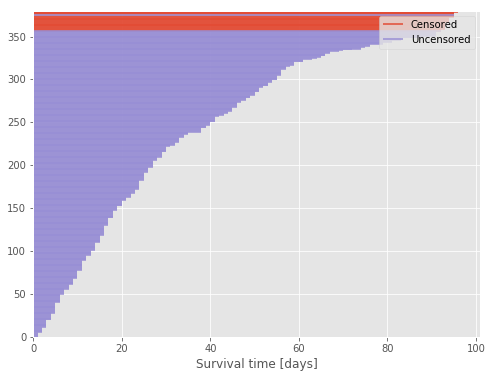

In [20]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 6))
blue, _, red = sns.color_palette()[:3]
ax.hlines(patients[df_sort.dead.values == 0], 0, df_sort[df_sort.dead.values == 0].t,
          color=blue, label='Censored');
ax.hlines(patients[df_sort.dead.values == 1], 0, df_sort[df_sort.dead.values == 1].t,
          color=red, label='Uncensored');

ax.set_xlim(left=0);
ax.set_xlabel('Survival time [days]');
ax.set_ylim(-0.25, n_patients + 0.25);
ax.legend(loc='top right');

In [21]:
interval_length = 4
interval_bounds = np.arange(0, df.t.max() + interval_length + 1, interval_length)
n_intervals = interval_bounds.size - 1
intervals = np.arange(n_intervals)

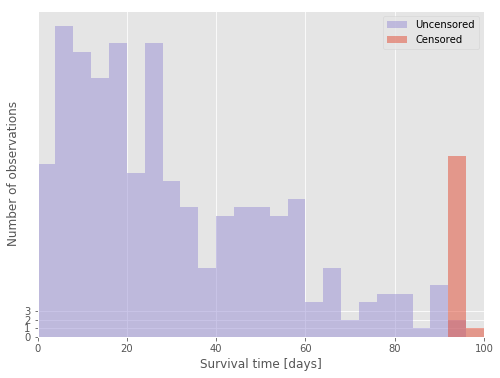

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(df[df.dead == 1].t.values, bins=interval_bounds,
        color=red, alpha=0.5, lw=0,
        label='Uncensored');
ax.hist(df[df.dead == 0].t.values, bins=interval_bounds,
        color=blue, alpha=0.5, lw=0,
        label='Censored');
ax.set_xlim(0, interval_bounds[-1]);
ax.set_xlabel('Survival time [days]');
ax.set_yticks([0, 1, 2, 3]);
ax.set_ylabel('Number of observations');
ax.legend();

In [23]:
last_period = np.floor((df.t - 0.01) / interval_length)

death = np.zeros((n_patients, n_intervals))
death[patients, last_period.astype(int)] = df.dead

In [24]:
exposure = np.greater_equal.outer(df.t, interval_bounds[:-1]) * interval_length
exposure[patients, last_period.astype(int)] = df.t - interval_bounds[last_period.astype(int)]

In [25]:
death_dat = {'N': len(df),
             'n_intervals':  n_intervals,
             #'death_array': death_array, 
             #'meta_array':  meta_array, 
             #'expo_array':  expo_array}
             'death':     death.astype(int),
             'skill_gap':   np.asarray(df.skill_gap),
             'exposure':  exposure}

In [26]:
#death_array = np.matrix.flatten(death)
#expo_array = np.matrix.flatten(exposure)
#therapy_array = np.asarray(df.therapy)
#meta_array = np.tile(meta_array, (n_intervals, 1))
#meta_array = meta_array.flatten('F')

In [27]:
death_array = np.matrix.flatten(death).astype(int)

In [28]:
expo_array = np.matrix.flatten(exposure)

In [29]:
skill_gap_array = np.asarray(df.skill_gap)
skill_gap_array = np.tile(skill_gap_array, (n_intervals, 1))
skill_gap_array = skill_gap_array.flatten('F')

In [30]:
base_id = np.arange(1,n_intervals+1)
print(str(base_id.shape))
base_id = np.tile(base_id, len(df))
base_id

(25,)


array([ 1,  2,  3, ..., 23, 24, 25])

In [31]:
death_dat2 ={'N':      len(df),
             'N_tot':  len(death_array),
             'T':      n_intervals,
             'M': 1,
             'base_id': base_id,
             'death_array':   death_array, 
             'x': skill_gap_array, 
             'expo':    expo_array}

In [32]:
expo_new  = expo_array[expo_array > 0]
N_tot_new = len(expo_new)
base_id_new = base_id[expo_array > 0]
death_array_new = death_array[expo_array > 0]
skill_gap_array_new = skill_gap_array[expo_array > 0]

In [33]:
death_dat3 ={'N':      len(df),
             'N_tot':  N_tot_new,
             'T':      n_intervals,
             'M': 1,
             'base_id': base_id_new,
             'death_array':   death_array_new, 
             'x': skill_gap_array_new, 
             'expo':    expo_new}

In [34]:
death_dat3['base_id']

array([1, 1, 2, ..., 2, 3, 4])

Stan code for equivalent poisson model using independent vague priors $\lambda_j \sim gamma(0.1,0.1)$. 
For covariate coeffient we have chosen $beta \sim normal(0,2).$

In [35]:
survival_model="""
data {
  int<lower=1> N;          // number of individuals
  int<lower=1> N_tot;      // total number of pseudo poisson observations
  int<lower=1> T;          // number of time intervals
  //int<lower=0> M;        // number of covariates
  int<lower=0, upper=T> base_id[N_tot];  // time interval index for each pseudo obs.
  
  int<lower=0, upper=1> death_array[N_tot];    // 1 for observed death, 0 all other cases
  vector[N_tot] x;                             // covariates

  vector<lower=0>[N_tot] expo;  // exposure time (time alive) in each interval
}

transformed data {
  vector[N_tot] log_expo = log(expo);  // log-duration for each timepoint
}
parameters {
  real beta;                       // regression coefficient
  vector<lower=0>[T] lambda0;  // baseline hazard for each timepoint t
}
model {
  beta ~ normal(0, 1);
  lambda0 ~ gamma(0.01,0.1);
  for (n_tot in 1:N_tot) {
    death_array[n_tot] ~ poisson_log(log(lambda0[base_id[n_tot]]) + log_expo[n_tot]   + x[n_tot] * beta );
  }
  
}
generated quantities {
  vector[N] log_lik;
  int n; 
  n = 1;
  log_lik = rep_vector(0,N);
  
  // log_lik for loo-psis
  for (n_tot in 1:N_tot) { 
      log_lik[n] += poisson_log_lpmf(death_array[n_tot]| log(lambda0[base_id[n_tot]])+log_expo[n_tot]+x[n_tot]*beta );
      
      // increment individual count if next time interval comes before the current 
      // only because of bad programming
      if (n_tot > 1){
          if (base_id[n_tot] <= base_id[n_tot-1]){
              n += 1;  
          }
      }
  }
}
"""

In [36]:
sm = pystan.StanModel(model_code=survival_model);

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cd6c69a4728ed788912e0aa5885e7b5b NOW.


In [37]:
fit = sm.sampling(data=death_dat3, algorithm="HMC", seed=10, iter=500, chains=4, warmup=100)

In [ ]:
fit

In [39]:
aa = fit.extract()

# Conclusion: The test therapy reduces the average hazard by approximately 8%

In [40]:
np.exp(aa['beta'].mean())

1.1350450501928

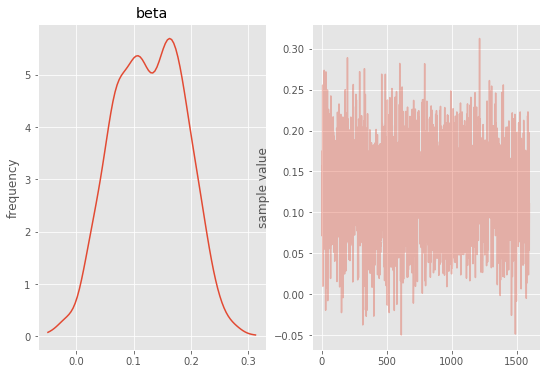

In [41]:
fit.traceplot('beta');

# Psis-loo

In [47]:
from psis import psisloo

In [43]:
np.shape(aa['log_lik'])

(1600, 380)

In [44]:
log_likelihood1 = aa['log_lik'].reshape(1600,-1)

In [45]:
loo, loos, ks = psisloo(log_likelihood1)

In [46]:
np.std(loos)

3.7939646763762394

In [47]:
# estimated number of effective parameters
computed_lppd = np.sum(np.log(np.mean(np.exp(log_likelihood1),axis=0)));
pl00cv = computed_lppd - loo;

In [48]:
computed_lppd

-1355.1479739942044

In [49]:
pl00cv

254.90464769970708

26 effective parameters

Text(0.5, 0, 'k')

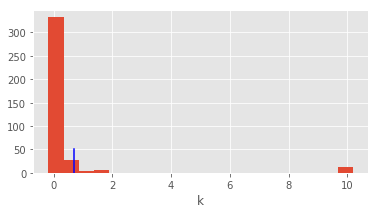

In [50]:
plt.figure(figsize=(6,3))
plt.hist(ks, bins=20)
plt.plot([0.7, 0.7],[0,50],"b")
plt.xlabel("k")

# Plot survival function

In [51]:
base_hazard = aa['lambda0']
base_hazard.shape

met_hazard = aa['lambda0'] * np.exp(np.atleast_2d(aa['beta']).T)
met_hazard.shape

(1600, 25)

In [52]:
def cum_hazard(hazard):
    return (interval_length * hazard).cumsum(axis=-1)

def survival(hazard):
    return np.exp(-cum_hazard(hazard))

In [53]:
def plot_with_hpd(x, hazard, f, ax, color=None, label=None, alpha=0.05):
    mean = f(hazard.mean(axis=0))
    
    percentiles = 100 * np.array([alpha / 2., 1. - alpha / 2.])
    hpd = np.percentile(f(hazard), percentiles, axis=0)
    
    ax.fill_between(x, hpd[0], hpd[1], color=color, alpha=0.25)
    ax.step(x, mean, color=color, label=label);

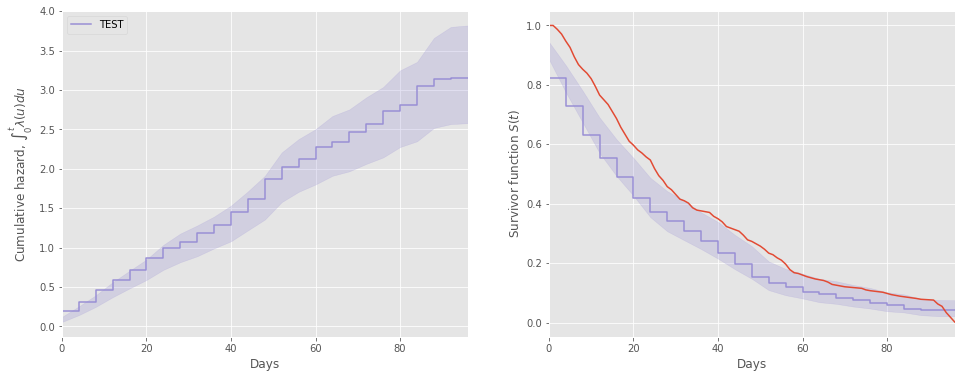

In [56]:
fig, (hazard_ax, surv_ax) = plt.subplots(ncols=2, sharex=True, sharey=False, figsize=(16, 6))

# plot_with_hpd(interval_bounds[:-1], base_hazard, cum_hazard,
#               hazard_ax, color=blue, label='Standard')
plot_with_hpd(interval_bounds[:-1], met_hazard, cum_hazard,
              hazard_ax, color=red, label='TEST')

hazard_ax.set_xlim(0, df.t.max());
hazard_ax.set_xlabel('Days');

hazard_ax.set_ylabel(r'Cumulative hazard, $\int_0^t \lambda(u)du$');

hazard_ax.legend(loc=2);

# plot_with_hpd(interval_bounds[:-1], base_hazard, survival,
#               surv_ax, color=blue)
plot_with_hpd(interval_bounds[:-1], met_hazard, survival,
              surv_ax, color=red)
#survivalstan.utils.plot_observed_survival(df=df[df['skill_gap'] == 0], event_col='dead', time_col='t', label='standard')
#survivalstan.utils.plot_observed_survival(df=df[df['skill_gap'] == 1], event_col='dead', time_col='t', label='test')
survivalstan.utils.plot_observed_survival(df=df, event_col='dead', time_col='t', label='test')

surv_ax.set_xlim(0, df.t.max());
surv_ax.set_xlabel('Days');

surv_ax.set_ylabel('Survivor function $S(t)$');

#fig.suptitle('Bayesian survival model');

# Time varying coefficient

In [35]:
survival_model_time_varying="""
data {
  int<lower=1> N;          // number of individuals
  int<lower=1> N_tot;      // total number of pseudo poisson observations
  int<lower=1> T;          // number of time intervals
  //int<lower=0> M;        // number of covariates
  int<lower=0, upper=40> base_id[N_tot];  // time interval index for each pseudo obs.
  
  int<lower=0, upper=1> death_array[N_tot];    // 1 for observed death, 0 all other cases
  vector[N_tot] x;                             // covariates

  vector<lower=0>[N_tot] expo;  // exposure time (time alive) in each interval
}

transformed data {
  vector[N_tot] log_expo = log(expo);  // log-duration for each timepoint
  // vector[N_tot] xx = 1-x;
}
parameters {
  vector[T] beta;              // regression coefficient
  vector<lower=0>[T] lambda0;  // baseline hazard for each timepoint t
}
model {
  beta ~ normal(0, 1);
  lambda0 ~ gamma(0.01,0.1);
  for (n_tot in 1:N_tot) {
    death_array[n_tot] ~ poisson_log(log(lambda0[base_id[n_tot]])+log_expo[n_tot]+x[n_tot]*beta[base_id[n_tot]]);
  }
  
}
generated quantities {
  vector[N] log_lik;
  int n; 
  n = 1;
  log_lik = rep_vector(0,N);
  
  // log_lik for loo-psis
  for (n_tot in 1:N_tot) { 
      log_lik[n] += poisson_log_lpmf(death_array[n_tot]| log(lambda0[base_id[n_tot]])+log_expo[n_tot]+x[n_tot]*beta );
      
      // increment individual count if next time interval comes before the current 
      // only because of bad programming
      if (n_tot > 1){
          if (base_id[n_tot] <= base_id[n_tot-1]){
              n += 1;  
          }
      }
  }
}
"""

In [36]:
sm_time = pystan.StanModel(model_code=survival_model_time_varying);

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1b6e79da15a5602a5ae909867df5d64c NOW.


In [37]:
fit_time = sm_time.sampling(data=death_dat3, algorithm="HMC", seed=1, iter=400, chains=4, warmup=100)

In [38]:
fit_time

Inference for Stan model: anon_model_1b6e79da15a5602a5ae909867df5d64c.
4 chains, each with iter=400; warmup=100; thin=1; 
post-warmup draws per chain=300, total post-warmup draws=1200.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0]        0.07    0.04   0.18  -0.32  -0.03   0.08   0.19   0.38     22   1.08
beta[1]         0.2  8.3e-3   0.14  -0.11    0.1   0.21   0.31   0.46    301   1.01
beta[2]        0.13    0.02   0.15  -0.19   0.04   0.13   0.23   0.41     95   1.02
beta[3]        0.02    0.02   0.18  -0.38  -0.09   0.03   0.13   0.34    131   1.02
beta[4]        0.03    0.01    0.2  -0.38  -0.11   0.05   0.16   0.38    235   1.01
beta[5]        0.23    0.01   0.18  -0.18   0.12   0.24   0.35   0.56    299   1.01
beta[6]        0.25    0.01   0.18  -0.11   0.14   0.26   0.37   0.58    264   1.03
beta[7]        0.25    0.02   0.24  -0.24   0.09   0.27    0.4   0.73    190   1.03
beta[8]       -0.47    0.01   0.42  -1.35  -0.74  -0.44  -

In [42]:
aa_time = fit_time.extract()

In [44]:
np.shape(aa_time['log_lik'])

(1200, 380)

In [48]:
from psis import psisloo

In [49]:
log_likelihood2 = aa_time['log_lik'].reshape(1200,-1)

In [50]:
loo2, loos2, ks2 = psisloo(log_likelihood2)

# k-value are larger than 0.7 and psis-loo estimate is therefore not applicable.

In [51]:
ks2[0:10]

array([2.42814844, 3.12814788, 3.70493479, 3.53488449, 1.46004513,
       3.46780565, 1.84218497, 1.91090038, 1.79241075, 3.02091075])

In [ ]:
def plot_with_hpd(x, hazard, f, ax, color=None, label=None, alpha=0.05):
    mean = f(hazard.mean(axis=0))
    
    percentiles = 100 * np.array([alpha / 2., 1. - alpha / 2.])
    hpd = np.percentile(f(hazard), percentiles, axis=0)
    
    ax.fill_between(x, hpd[0], hpd[1], color=color, alpha=0.25)
    ax.step(x, mean, color=color, label=label);

In [70]:
base_hazard_t = aa_time['lambda0']
base_hazard_t.shape

met_hazard_t = aa_time['lambda0'] * np.exp(np.atleast_2d(aa_time['beta']))
met_hazard.shape

(200, 25)

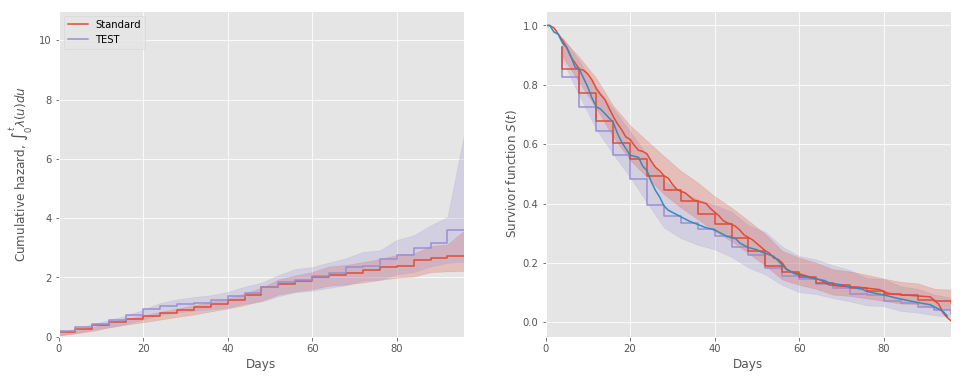

In [76]:
fig, (hazard_ax, surv_ax) = plt.subplots(ncols=2, sharex=True, sharey=False, figsize=(16, 6))

plot_with_hpd(interval_bounds[:-1], met_hazard_t, cum_hazard,
              hazard_ax, color=blue, label='Standard')
plot_with_hpd(interval_bounds[:-1], base_hazard_t, cum_hazard,
              hazard_ax, color=red, label='TEST')


hazard_ax.set_xlim(0, df.t.max());
hazard_ax.set_ylim(0, 11);

hazard_ax.set_xlabel('Days');

hazard_ax.set_ylabel(r'Cumulative hazard, $\int_0^t \lambda(u)du$');
hazard_ax.legend(loc=2);


##################################################################################


plot_with_hpd(interval_bounds[1:], base_hazard_t, survival,
              surv_ax, color=red)
plot_with_hpd(interval_bounds[1:], met_hazard_t, survival,
              surv_ax, color=blue)
survivalstan.utils.plot_observed_survival(df=df[df['skill_gap'] == 0], event_col='dead', time_col='t', label='standard')
survivalstan.utils.plot_observed_survival(df=df[df['skill_gap'] == 1], event_col='dead', time_col='t', label='test')

surv_ax.set_xlim(0, df.t.max());
surv_ax.set_xlabel('Days');

surv_ax.set_ylabel('Survivor function $S(t)$');

#fig.suptitle('Bayesian survival model');